# Time series machine learning for Wash WC

In [2]:
'''
File name: time_series_ml.py
Author: 930233
Date created: 01/04/2021
Date last modified: 25/05/2013
Python Version: 3.7
'''

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from scripts.feature_generator import FeatureGenerator

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# Setting parameters

In [2]:
# Parameters for feature engineering
WC = "md_wash1_wc"
DATE = "md_wash1_proc_date"
COUNT = "magd"
FAIL = "remark"
DF_COLS = {"wc" : WC,
           "wc_date" : DATE,
           "count" : COUNT,
           "fail" : FAIL}
FEATURES = ["cs_osr_standardized_mean", "magd", "no2_mean", "di_recirc_anomaly_sum", "mst2_anomaly_sum", "mst1_anomaly_sum", "fail_percentage"]
LABEL = ["fail_percentage"]

WINDOW_SIZE = 3
NO_DAY_TO_PRED = 1
N_FEATURES = len(FEATURES)

# 1. Feature Engineering for TRAIN dataset
Date range: 2020-12-11 - 2021-03-11

### 1.1 Load datasets

In [3]:
# Load datasets
df = pd.read_csv("datasets\CIM_TA_EC@1088411_train.csv", usecols=[WC, DATE, COUNT, FAIL])
sensor_df = pd.read_csv("datasets\cleaned_sensor_weather_train.csv")

### 1.2 Generate pivot table

In [4]:
train_fg = FeatureGenerator(df=df, 
                      sensor_df=sensor_df, 
                      df_cols=DF_COLS, 
                      features=FEATURES, 
                      labels=LABEL,
                      win_size=WINDOW_SIZE, 
                      day_pred=NO_DAY_TO_PRED, 
                      df_date_offset=90, 
                      max_date="2021-03-11", 
                      wash=True)

print(train_fg)
# Generate pivot table
train_fg.gen_table(min_data=0.7, interpolate=True)

Dataset Length: 699
WC: md_wash1_wc
Window Size: 3
Date Range: 2020-12-11 - 2021-03-11
Features: ['cs_osr_standardized_mean', 'magd', 'no2_mean', 'di_recirc_anomaly_sum', 'mst2_anomaly_sum', 'mst1_anomaly_sum', 'fail_percentage']
Days to predict: 1


### 1.2.1 Generated pivot table

In [5]:
train_fg.df.head()

cs_osr_standardized_mean                                             magd                                      no2_mean  \
md_wash1_wc                           OW601     OW602     OW603     OW604     OW606    OW601    OW602   OW603    OW604    OW606      OW601   
md_wash1_proc_date                                                                                                                           
2020-12-11                        -0.051605 -0.092244  1.018481 -0.128627  0.501136  22816.0   7885.0   239.0  10705.0   8448.0  22.347826   
2020-12-12                         0.212396 -0.088542  1.018481  0.010414  0.585123  24234.0   6826.0   239.0  11501.0   7172.0  22.347826   
2020-12-13                         0.004854 -0.086254  1.899745  0.119975  0.667587   8683.0   7065.0   239.0   8479.0   4851.0  19.304348   
2020-12-14                        -0.409541 -0.256910 -1.681400 -0.216714  0.569440  10499.0   7770.0  1394.0  11656.0  12116.0  13.521739   
2020-12-15                        -0.394671 -0.496693 -2.375137 -0.748968  0.422946  22958.0  11915.0  1599.0  16177.0  13871.0  21.217391   

                                                               di_recirc_anomaly_sum                                    mst2_anomaly_sum           \
md_wash1_wc             OW602      OW603      OW604      OW606                 OW601    OW602   OW603    OW604    OW606            OW601    OW602   
md_wash1_proc_date                                                                                                                                  
2020-12-11          22.347826  22.347826  22.347826  22.347826               54799.0  36675.0  1520.0  28732.0  43901.0          54604.0  37558.0   
2020-12-12          22.347826  22.347826  22.347826  22.347826               51789.0  28596.0  1520.0  36720.0  43995.0          52196.0  28998.0   
2020-12-13          19.304348  19.304348  19.304348  19.304348               42991.0  36986.0   542.0  40293.0  27386.0          43190.0  37842.0   
2020-12-14          13.521739  13.521739  13.521739  13.521739               37507.0  40068.0  3170.0  36317.0  59014.0          37986.0  40792.0   
2020-12-15          21.217391  21.217391  21.217391  21.217391               55411.0  50370.0  2955.0  50985.0  65489.0          55097.0  51170.0   

                                             mst1_anomaly_sum                                    fail_percentage                                \
md_wash1_wc          OW603    OW604    OW606            OW601    OW602   OW603    OW604    OW606           OW601     OW602     OW603     OW604   
md_wash1_proc_date                                                                                                                               
2020-12-11          1481.0  28669.0  43100.0          53051.0  37670.0  1390.0  29101.0  43955.0        0.002454  0.001649  0.004184  0.002335   
2020-12-12          1481.0  37196.0  43103.0          50116.0  28821.0  1390.0  37761.0  44005.0        0.004126  0.002930  0.004184  0.003130   
2020-12-13           527.0  40399.0  26631.0          42005.0  37434.0   592.0  41258.0  27108.0        0.005067  0.003963  0.012552  0.001415   
2020-12-14          3226.0  35984.0  57848.0          36835.0  40623.0  3417.0  36679.0  59016.0        0.001048  0.006178  0.004304  0.001287   
2020-12-15          2966.0  50666.0  64140.0          53502.0  51012.0  3220.0  51694.0  65439.0        0.002788  0.006966  0.002502  0.002596   

                              
md_wash1_wc            OW606  
md_wash1_proc_date            
2020-12-11          0.001776  
2020-12-12          0.002510  
2020-12-13          0.003298  
2020-12-14          0.005612  
2020-12-15          0.007281

### 1.3 Generate Train dataset
**Note:**   
Train and test datasets are formatted differently   
   
Train: Features and labels for ALL WCs are combined together as we want to use all data to train the model   
Test: Features and labels are seperate by WCs   
   
**Train Test data shape:**   
Train: (num_data, win_size, features)   
Test: (num_data, win_size)   

In [6]:
# Generate train
train_fg.df_split(train_size=1)
train = train_fg.train
train_fg.save_scaler("../minmaxscaler/cim_sensor_train_v2.pkl") # save minmax scaler

### 1.3.1 Train dataset shape

In [7]:
try:
    print("Train_features:", train[0].shape)
    print("Train_labels:", train[1].shape)
except:
    print("No Train sets")
    
try:
    print("Num Test sets:", len(test))
except:
    print("No Test sets")

Train_features: (440, 3, 7)
Train_labels: (440, 1)
No Test sets


# 2. Feature Engineering for TEST dataset
Date range: 2021-03-14 - 2021-03-17

### 2.1 Load datasets

In [8]:
# Load datasets
df = pd.read_csv("datasets\CIM_TA_EC@1088411_test.csv", usecols=[WC, DATE, COUNT, FAIL])
sensor_df = pd.read_csv("datasets\cleaned_sensor_weather_test.csv")

### 2.2 Generate pivot table

In [9]:
test_fg = FeatureGenerator(df=df, 
                      sensor_df=sensor_df, 
                      df_cols=DF_COLS, 
                      features=FEATURES, 
                      labels=LABEL,
                      win_size=WINDOW_SIZE, 
                      day_pred=NO_DAY_TO_PRED, 
                      df_date_offset=3, 
                      max_date="2021-03-17", 
                      wash=True)

print(test_fg)
# Generate pivot table
test_fg.gen_table(min_data=0.5, interpolate=True)

Dataset Length: 31
WC: md_wash1_wc
Window Size: 3
Date Range: 2021-03-14 - 2021-03-17
Features: ['cs_osr_standardized_mean', 'magd', 'no2_mean', 'di_recirc_anomaly_sum', 'mst2_anomaly_sum', 'mst1_anomaly_sum', 'fail_percentage']
Days to predict: 1


### 2.2.1 Generated pivot table

In [10]:
test_fg.df.head()

cs_osr_standardized_mean                                  magd                            no2_mean                        \
md_wash1_wc                           OW601     OW603     OW604     OW606   OW601    OW603   OW604   OW606      OW601      OW603      OW604   
md_wash1_proc_date                                                                                                                            
2021-03-14                        -0.163314 -0.107774  0.087006  0.015836  2044.0  10911.0  6619.0  4334.0  17.869565  17.869565  17.869565   
2021-03-15                        -0.163314 -0.107774  0.087006  0.015836  2338.0  10668.0  9690.0  6119.0   9.956522   9.956522   9.956522   
2021-03-16                         0.223969  0.520427  0.348539 -0.457426  3386.0   5869.0  4522.0  1389.0  11.739130  11.739130  11.739130   
2021-03-17                         0.223969  0.520427  0.348539 -0.457426   520.0   3810.0  3755.0   780.0  13.227273  13.227273  13.227273   

                              di_recirc_anomaly_sum                            mst2_anomaly_sum                            mst1_anomaly_sum  \
md_wash1_wc             OW606                 OW601    OW603    OW604    OW606            OW601    OW603    OW604    OW606            OW601   
md_wash1_proc_date                                                                                                                            
2021-03-14          17.869565                4988.0  15748.0  16165.0  22385.0           5148.0  15926.0  16242.0  22574.0           5416.0   
2021-03-15           9.956522                4988.0  15748.0  16165.0  22385.0           5148.0  15926.0  16242.0  22574.0           5416.0   
2021-03-16          11.739130                1321.0   1176.0   1076.0   1433.0           1319.0   1136.0   1086.0   1124.0           1353.0   
2021-03-17          13.227273                1321.0   1176.0   1076.0   1433.0           1319.0   1136.0   1086.0   1124.0           1353.0   

                                              fail_percentage                                
md_wash1_wc           OW603    OW604    OW606           OW601     OW603     OW604     OW606  
md_wash1_proc_date                                                                           
2021-03-14          16129.0  16579.0  23188.0        0.005871  0.004033  0.003626  0.003922  
2021-03-15          16129.0  16579.0  23188.0        0.004277  0.004781  0.003406  0.002942  
2021-03-16           1178.0   1126.0    962.0        0.003839  0.004260  0.002654  0.002880  
2021-03-17           1178.0   1126.0    962.0        0.001923  0.002625  0.002130  0.003846

### 2.3 Generate Test dataset
**Note:**   
Train and test datasets are formatted differently   
   
Train: Features and labels for ALL WCs are combined together as we want to use all data to train the model   
Test: Features and labels are seperate by WCs   
   
**Train Test data shape:**   
Train: (num_data, win_size, features)   
Test: (num_data, win_size)   

In [11]:
# Only generate test
test_fg.load_scaler("../minmaxscaler/cim_weather_sensor_scaler_v1.pkl") # load minmax scaler
test_fg.df_split(train_size=0)
test = test_fg.test

### 2.3.1 Test dataset shape

In [12]:
try:
    print("Train_features:", train[0].shape)
    print("Train_labels:", train[1].shape)
except:
    print("No Train sets")
try:
    print("Num Test sets:", len(test))
except:
    print("No Test sets")

Train_features: (440, 3, 7)
Train_labels: (440, 1)
Num Test sets: 4


# 3. Training machine learning model

### 3.1 Model parameters

In [13]:
SCALER = train_fg.scaler

### 3.2 Building Deep Neural Network

In [41]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(100, WINDOW_SIZE, activation="relu", input_shape=(WINDOW_SIZE, N_FEATURES)),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NO_DAY_TO_PRED)
    ])

    model.summary()
    model.compile(optimizer="adam", loss="mae")
    
    return model

model = build_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 100)            2200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
flatten_6 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 82,701
Trainable params: 82,701
Non-trainable params: 0
_________________________________________________________________


### 3.3 Training model using TRAIN dataset

In [42]:
history = model.fit(x=train[0], y=train[1], validation_split=0.33, epochs=200)

Epoch 1/200
10/10 [==============================] - 0s 46ms/step - loss: 0.1063 - val_loss: 0.1225
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0749 - val_loss: 0.0955
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0600 - val_loss: 0.0812
Epoch 4/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0502 - val_loss: 0.0690
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0426 - val_loss: 0.0609
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 0.0591
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0345 - val_loss: 0.0520
Epoch 8/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0327 - val_loss: 0.0466
Epoch 9/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0283 - val_loss: 0.0433
Epoch 10/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0233 - val_loss: 0.0400
Epoch 11

10/10 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0093
Epoch 84/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0092
Epoch 85/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 86/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 87/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 88/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0108
Epoch 89/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0124
Epoch 90/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 91/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0081
Epoch 92/200
10/10 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0084
Epoch 93/200


### 3.4 Training Loss
Loss shows far the predicted values deviate from the actual values in the training data

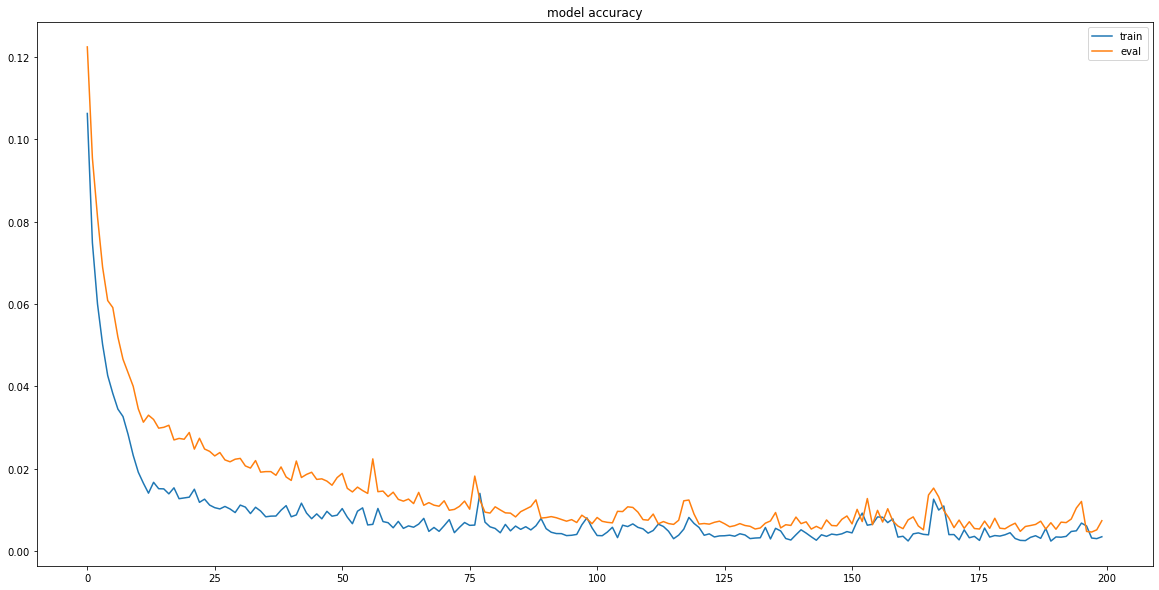

In [43]:
plt.figure(figsize=(20,10))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="eval")
plt.title("model accuracy")
plt.legend()
plt.savefig("results/model_accuracy.png")
plt.show()

In [44]:
# Save model for future use
model.save_weights('models/cim_dnn_model_v2')

# 4. Testing model

### 4.1 Load trained weights into model

In [45]:
model = build_model()

model.load_weights('models/cim_dnn_model_v2') # Load weights from previously trained model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1, 100)            2200      
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
flatten_7 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 82,701
Trainable params: 82,701
Non-trainable params: 0
_________________________________________________________________


### 4.2 Predicting fail_percentage for TEST dataset

In [46]:
date_diff = (test_fg.max_date - test_fg.min_date).days
date_range = [datetime.strftime(test_fg.min_date + timedelta(x), "%Y-%m-%d") for x in range(date_diff + 1)]

In [47]:
def model_predict(model, data):
    pred = model.predict(data[0])
    
    original = [[0 for y in range(N_FEATURES-1)] + [float(data[0][0][x][-1]) * 100] for x in range(len(data[0][0]))]
    actual_pred = [[0 for y in range(N_FEATURES-1)] + [float(data[1][x]) * 100] for x in range(len(data[1]))]
    prediction = [[0 for y in range(N_FEATURES-1)] + [float(pred[x]) * 100] for x in range(len(pred))]
    
    rev_actual_pred = SCALER.inverse_transform(actual_pred)[:, -1]
    rev_org = SCALER.inverse_transform(original)[:, -1]
    rev_pred = SCALER.inverse_transform(prediction)[:, -1]
    
    mae = mean_absolute_error(rev_actual_pred, rev_pred)
    
    return rev_org, rev_pred, rev_actual_pred, mae

### 4.3 Plotting results

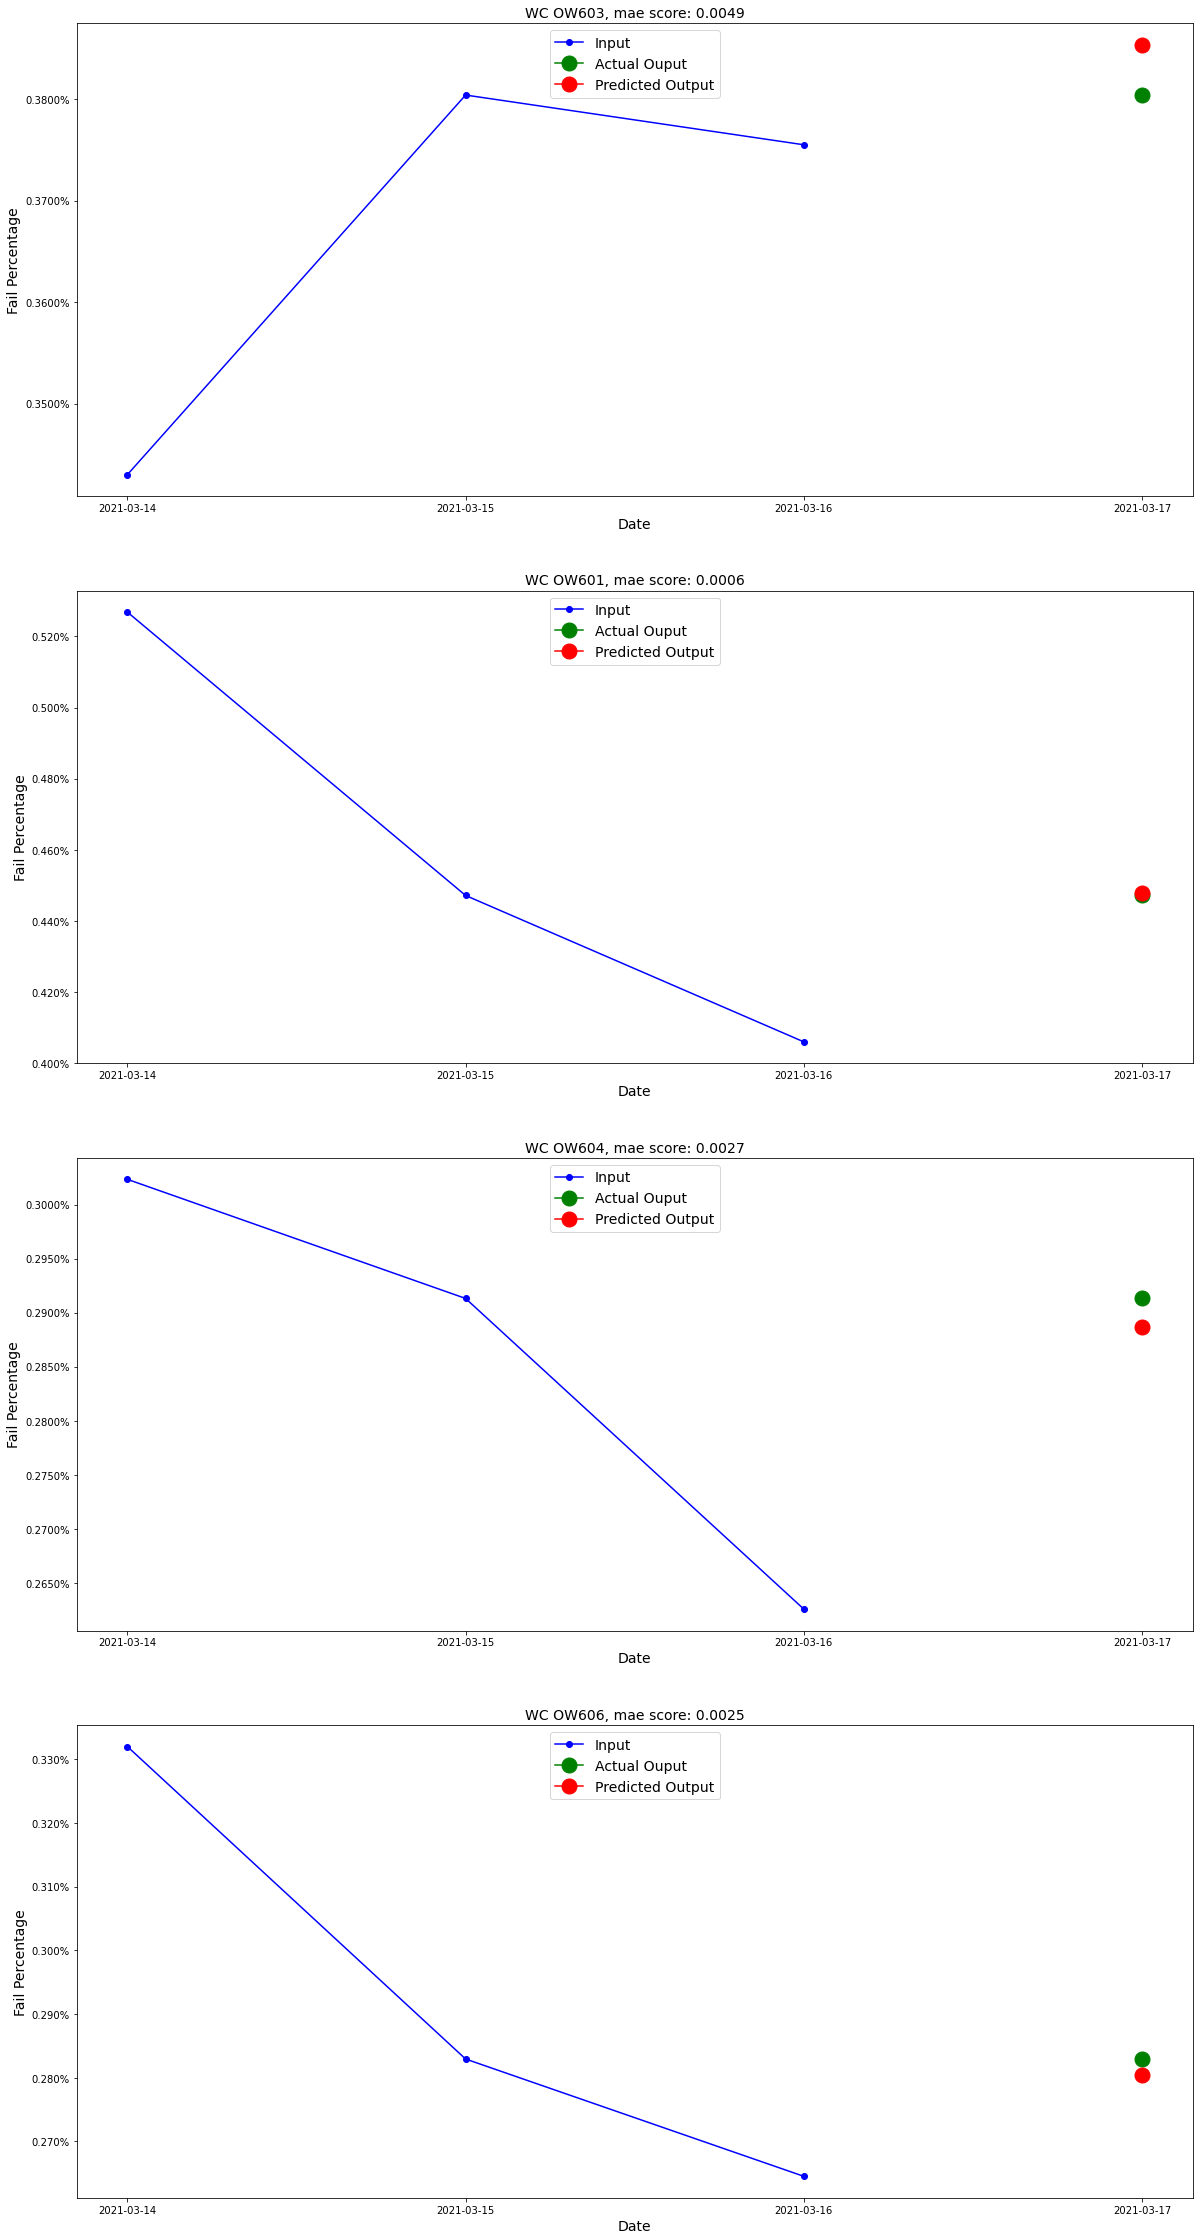

In [50]:
font_size = 14
all_mae = []

fig, ax = plt.subplots(len(test), figsize=(20, 10 * len(test)))
for index, k in enumerate(test.keys()):
    rev_org, rev_pred, rev_actual_pred, mae = model_predict(model, test[k])
    all_mae.append(mae)

    ax[index].plot(rev_org, marker="o", color="blue", label="Input")
    ax[index].plot(WINDOW_SIZE, rev_actual_pred, marker="o", color="green", ms=15, label="Actual Ouput")
    ax[index].plot(WINDOW_SIZE, rev_pred, marker="o", ms=15, color="red", label="Predicted Output")
    ax[index].legend(loc="upper center", prop={'size': font_size})
    ax[index].set_title("WC {}, mae score: {:.4f}".format(k, mae), fontsize=font_size)
    ax[index].set_ylabel("Fail Percentage", fontsize=font_size)
    ax[index].set_xlabel("Date", fontsize=font_size)
    ax[index].set_xticks([x for x in range(date_diff + 1)])
    ax[index].set_xticklabels(date_range)
    ax[index].yaxis.set_major_formatter(mtick.PercentFormatter())
    
    extent = ax[index].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f"results/{k}_{test_fg.min_date}_{test_fg.max_date}_result_plot.png", bbox_inches=extent.expanded(1.2, 1.2))

### 4.4 Overall performance of model
Mean Average Error (MAE) is the sum of absolute differences between our target and predicted variables. It measures the average magnitude of errors in a set of predictions, without considering their directions.

In [51]:
mae_mean = sum(all_mae) / len(all_mae)
print("Average MAE: {:.4f}".format(mae_mean))

Average MAE: 0.0027
